    核密度估计（kernel density estimation， KDE）
    算法将高斯混合理念扩展到了逻辑极限（logical extreme）。它通过对每个点生成高斯分布
    的混合成分，获得本质上是无参数的密度评估器。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set()

KDEd的由来:直方图

In [2]:
#直方图将数据分成若干区间，统计落入每个区间的点的数量

def make_data(N,f=0.3,rseed=1):
    rg = np.random.RandomState(rseed)
    x = rg.randn(N)
    x[int(f*N):]+=5
    return x

#制造数据，将后三分之二的数据点加5

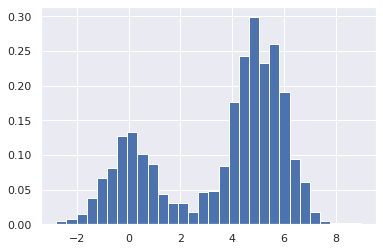

In [6]:
x = make_data(1000)
hist = plt.hist(x,bins=30,density=True)

#density=True意味着区间的高度不反映统计频次，而是反映概率密度

In [22]:
#概率密度只是简单改变了y轴的比例，相对高度与频次直方图一致
#验证

density,bins,patches = hist
widths = bins[1:]-bins[:-1]
(density*widths).sum()

1.0

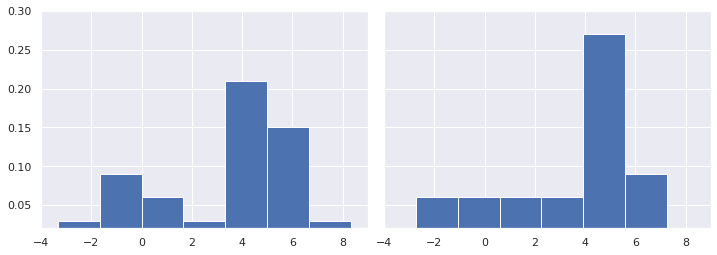

In [29]:
#区间大小和位置的选择不同，产生的统计特征也不同

x = make_data(20)

bins = np.linspace(-5,10,10)
fig,ax = plt.subplots(1,2,figsize=(12,4),sharex = True,sharey= True,
                      subplot_kw=dict(xlim=(-4,9),ylim=(0.02,0.3)))
fig.subplots_adjust(wspace=0.05)
for i,offset in enumerate([0.0,0.6]):
    ax[i].hist(x,bins=bins+offset,density=True)
    ax[i].plot(x,np.full_like(x,-0.01),'|k',markeredgewidth=1)
#np.full_like()返回与给定数组具有相同形状和类型的数组。并且数组中元素的值是fill_value的值    

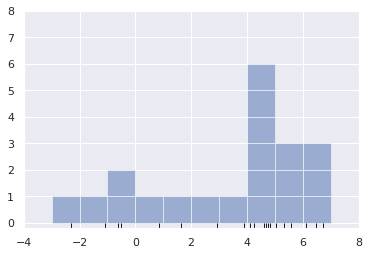

In [30]:
#左图附加的偏移量为0，产生的直方图呈现双峰的分布
#右图偏移量0.6，产生的直方图单峰且带长尾

#方块堆叠直方图
fig,ax = plt.subplots()
bins = np.arange(-3,8)
ax.plot(x,np.full_like(x,-0.1),'|k',markeredgewidth=1 )
for count,edge in zip(*np.histogram(x,bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge,i),1,1,alpha=0.5))
    ax.set_xlim(-4,8)
    ax.set_ylim(-0.2,8)


(-4.0, 8.0, -0.2, 8.0)

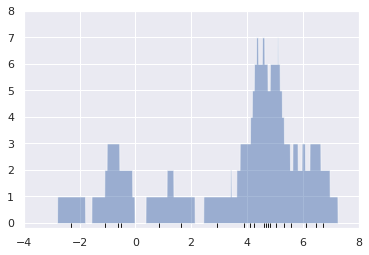

In [31]:
x_d = np.linspace(-4,8,2000)
density = sum((abs(xi-x_d)<0.5) for xi in x)

plt.fill_between(x_d,density,alpha=0.5)
plt.plot(x,np.full_like(x,-0.1),"|k",markeredgewidth=1)
plt.axis([-4,8,-0.2,8])

(-4.0, 8.0, -0.2, 5.0)

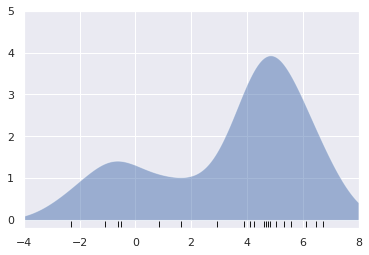

In [32]:
#高斯函数使曲线平滑

from scipy.stats import norm

x_d = np.linspace(-4,8,1000)
density=sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d,density,alpha=0.5)
plt.plot(x,np.full_like(x,-0.1),'|k',markeredgewidth=1)
plt.axis([-4,8,-0.2,5])

#图像由每个点所在位置的高斯分布构成的

核密度估计的实际应用

(-0.02, 0.22)

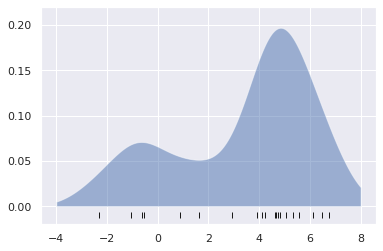

In [35]:
#sklearn中的KernelDensity

from sklearn.neighbors import KernelDensity

#实例化kde对象，bandwidth核带宽，控制每个点的核的大小
kde = KernelDensity(bandwidth=1.0,kernel='gaussian')
kde.fit(x[:,None])

#计算概率密度的对数值
log_prob = kde.score_samples(x_d[:,None])

#np.exp(log_prob)计算对数变换之前的概率密度值
plt.fill_between(x_d,np.exp(log_prob),alpha=0.5)
plt.plot(x,np.full_like(x,-0.01),"|k",markeredgewidth=1)
plt.ylim(-0.02,0.22)

**通过交叉检验选择带宽**

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidth = 10**np.linspace(-1,1,100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                   param_grid={'bandwidth':bandwidth},
                   cv = LeaveOneOut())
grid.fit(x[:,None]);

In [44]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

示例:不是很朴素的贝叶斯

*一般分类器的生成算法如下所示*:
* 通过标签分割训练数据。
* 为每个集合拟合一个KDE来获得数据的生成模型，这样就可以用任意$x$观察值和$y$标签计算出似然估计值    $P(x|y)$。
* 根据训练集中每一类的样本数量，计算每一类的先验概率$P(y)$。
* 对于一个未知的点$P(x)$，每一类的后验概率是$P(x|y)\varpropto{P(x|y)P(y)}$，而后验概率最大的类就是分配给该点的标签。

In [55]:
#自定义KDE分类器类

from sklearn.base import BaseEstimator,ClassifierMixin

class KDEclassifier(BaseEstimator,ClassifierMixin):
    
    """基于KDE的贝叶斯生成分类
    
    参数
    ------------
    bandwidth:float
    每个类中的核带宽
    
    kernel:str
    核函数名称，传递给KernelDensity
    
    """
    
    def __init__(self,bandwidth=1.0,kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
    
    def fit(self,X,y):
        self.classes_ = np.sort(np.unique(y))#返回不同的类别值
        training_sets = [X[y==yi] for yi in self.classes_]#每一类包含的数据
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,kernel=self.kernel).fit(Xi)
                       for Xi in training_sets] 
        #对每一类包含的数据用KernelDensity进行训练
        self.logpriors_ = [np.log(Xi.shape[0]/X.shape[0]) 
                          for Xi in training_sets]#计算每一类的先验概率
        return self
    
    def predict_proba(self,X):
        logprobs = np.vstack([model.score_samples(X) for model in self.models_]).T
        #计算由每个类的kerneldensity计算出来的对数概率密度
        result = np.exp(logprobs+self.logpriors_)
        #先把似然估计乘以先验概率乘积的结果还原为原本的概率密度值
        return result/result.sum(1,keepdims=True)
        #归一化处理，返回每个类概率的数组shape=[n_samples,n_classes]
    def predict(self,X):
        return self.classes_[np.argmax(self.predict_proba(X),1)]
        #返回概率值最大的类

**使用自定义评估器**

In [58]:
from sklearn.datasets import load_digits

digits = load_digits()
bandwidth = 10**np.linspace(0,2,100)
grid = GridSearchCV(KDEclassifier(),{'bandwidth':bandwidth})
grid.fit(digits.data,digits.target)

#与原书中的写法不同，原因是sklearn版本不同，此处为sklearn0.21以后写法
scores = grid.cv_results_['mean_test_score']

{'bandwidth': 6.135907273413174}
accuracy =  0.9677298050139276


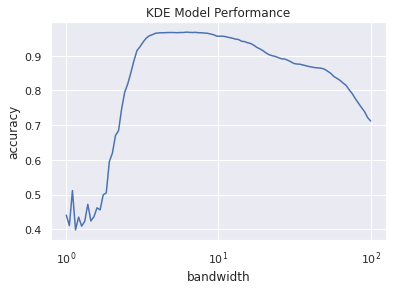

In [59]:
#画出交叉验证曲线，用交叉检验值作带宽函数

plt.semilogx(bandwidth,scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy = ',grid.best_score_)

In [60]:
#朴素贝叶斯分类器的分类性能

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(),digits.data,digits.target).mean()

#朴素贝叶斯较我们定义的KDE分类器效果很差

0.8069281956050759